In [381]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import validation_curve

In [382]:
df = pd.read_csv('./dataset/heart.csv')

In [383]:
# some notes about the attributes:
#
# *The labeling of multiple categorical attrubutes from the UCI website is different from the Kaggle website
# *there are: cp, slope, and thal
#
# Categorical Factors:
# age: age in years
# sex: (1 = male; 0 = female)
# cp: chest pain type, (1: typical angina; 
#                       2: atypical angina; 
#                       3: non-anginal pain; 
#                       4: asymptomatic)    #0,1,2,3?
# fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
# restecg: resting electrocardiographic results, 
#         (0: normal, 
#          1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV),
#          2: showing probable or definite left ventricular hypertrophy by Estes' criteria)
# exang: exercise induced angina (1 = yes; 0 = no)
# slope: the slope of the peak exercise ST segment
#       (1: upsloping
#        2: flat
#        3: downsloping)    #0,1,2?
# ca: number of major vessels (0-3) colored by flourosopy
# thal: 3 = normal; 6 = fixed defect; 7 = reversable defect    #1,2,3?
#
# Numeric Factors:
# age: age in years
# trestbps: resting blood pressure (in mm Hg on admission to the hospital)
# chol: serum cholestoral in mg/dl
# thalach: maximum heart rate achieved
# oldpeak: ST depression induced by exercise relative to rest
# 
# Dependent Variable:
# target: diagnosis of heart disease (angiographic disease status)
#        (0: < 50% diameter narrowing
#         1: > 50% diameter narrowing)

In [384]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [385]:
df.info()  ##turns out no NaN values, but still need to check for other invalid values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


# Data Cleaning

In [386]:
# a function to detect invalid entries
# takes a row in the dataframe
# returns a boolean variable, True for valid data, False for invalid data
# it could print a better explained message, but I think the short version is fine for now.
def CheckValid(row):
    #first check numeric variables
    if row['age'] < 0 :
        print('invalid age')
        return False
    elif row['trestbps'] < 0:
        print('invalid trestbps')
        return False
    elif row['chol'] < 0:
        print('invalid chol')
        return False
    elif row['thalach'] < 0:
        print('invalid thalach')
        return False
    elif row['oldpeak'] < 0:
        print('invalid oldpeak')
        return False
    #then check categorical variables
    elif row['sex'] not in [0,1]:
        print('invalid sex')
        return False
    elif row['cp'] not in [0,1,2,3]:
        print('invalid cp')
        return False
    elif row['fbs'] not in [0,1]:
        print('invalid fbs')
        return False
    elif row['restecg'] not in [0,1,2]:
        print('invalid restecg')
        return False
    elif row['exang'] not in [0,1]:
        print('invalid exang')
        return False
    elif row['slope'] not in [0,1,2]:
        print('invalid slope')
        return False
    elif row['ca'] not in [0,1,2,3]:
        print('invalid ca')
        print(row['ca'])
        return False
    elif row['thal'] not in [1,2,3]:
        print('invalid thal')
        return False
    elif row['target'] not in [0,1]:
        print('invalid target')
        return False
        
    return True


In [387]:
remove_list = []

#traverse rows in dataframe to check if valid
for i in range(len(df)):
    if not CheckValid(df.loc[i]):
        remove_list.append(i)
        
print(remove_list)

invalid thal
invalid ca
4.0
invalid ca
4.0
invalid ca
4.0
invalid ca
4.0
invalid ca
4.0
invalid thal
[48, 92, 158, 163, 164, 251, 281]


In [388]:
# remove invalid datas
df_cleaned = df.drop(remove_list)

In [389]:
df_cleaned   # 296 valid data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


# Outlier detection

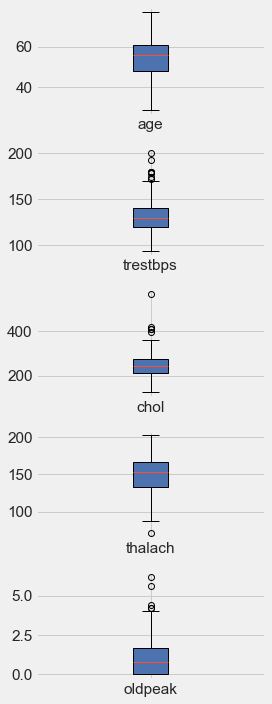

In [390]:
non_categ = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
# print(list(df_cleaned.columns).index(col)+1)
fig, a = plt.subplots(5, 1, figsize=(4,10))
idx = 0

for col in df_cleaned[non_categ]: 
    a[idx].boxplot(df_cleaned[col], patch_artist=True, labels = [col])
    a[idx].set_aspect('auto')
    idx = idx + 1
    
plt.tight_layout()
plt.show()

There are a lot of outliers in oldpeak and chol, which won't be useful for training our model. Right now I've used IsolationForest which seems to work fine:

In [391]:
data_cpy = df_cleaned[non_categ].copy()
detector = IsolationForest(n_jobs=-1, random_state=1) #control random_state
predicted = detector.fit_predict(data_cpy)

print("Isolation Forest:")
print(pd.crosstab(predicted, columns=['count']))

if_outcome = np.where(predicted == -1)
df_cleaned_if = df_cleaned.drop(df_cleaned.index[if_outcome[0]])

Isolation Forest:
col_0  count
row_0       
-1        34
 1       262


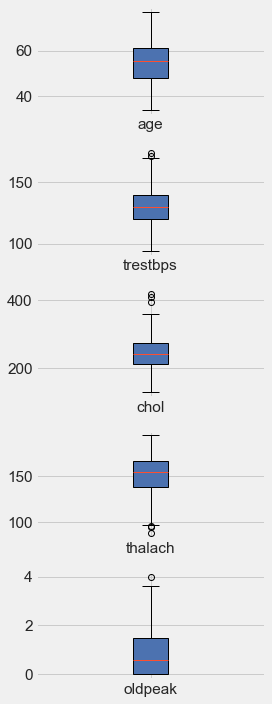

In [392]:
fig, a = plt.subplots(5, 1, figsize=(4,10))
idx = 0

for col in df_cleaned_if[non_categ]: 
    a[idx].boxplot(df_cleaned_if[col], patch_artist=True, labels = [col])
    a[idx].set_aspect('auto')
    idx = idx + 1
    
plt.tight_layout()
plt.show()

In [393]:
detector = LocalOutlierFactor(n_jobs = -1)
predicted = detector.fit_predict(data_cpy)

print("Local Outlier Factor:")
print(pd.crosstab(predicted, columns=['count']))

lof_outcome = np.where(predicted == -1)
df_cleaned_lof = df_cleaned.drop(df_cleaned.index[lof_outcome[0]])

Local Outlier Factor:
col_0  count
row_0       
-1        10
 1       286


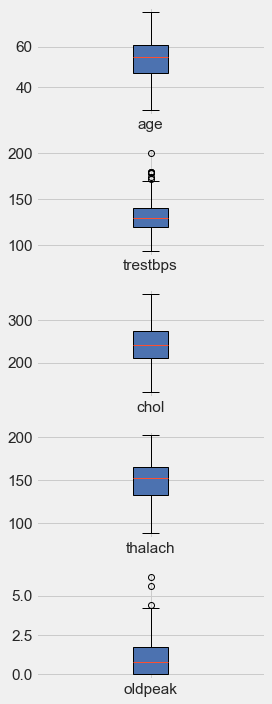

In [394]:
fig, a = plt.subplots(5, 1, figsize=(4,10))
idx = 0

for col in df_cleaned_lof[non_categ]: 
    a[idx].boxplot(df_cleaned_lof[col], patch_artist=True, labels = [col])
    a[idx].set_aspect('auto')
    idx = idx + 1
    
plt.tight_layout()
plt.show()

In [395]:
print("Size of intersection for lof and if: ", len(np.intersect1d(lof_outcome, if_outcome)))

Size of intersection for lof and if:  7


In [396]:
#Analyze removed outliers
df_cleaned.iloc[if_outcome[0]]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
42,45,1,0,104,208,0,0,148,1,3.0,1,0,2,1
53,44,0,2,108,141,0,1,175,0,0.6,1,0,2,1
65,35,0,0,138,183,0,1,182,0,1.4,2,0,2,1
72,29,1,1,130,204,0,0,202,0,0.0,2,0,2,1
85,67,0,2,115,564,0,0,160,0,1.6,1,0,3,1
101,59,1,3,178,270,0,0,145,0,4.2,0,0,3,1
110,64,0,0,180,325,0,1,154,1,0.0,2,0,2,1
111,57,1,2,150,126,1,1,173,0,0.2,2,1,3,1
124,39,0,2,94,199,0,1,179,0,0.0,2,0,2,1


In [397]:
#df_cleaned = df_cleaned_if
#df_cleaned.reset_index(drop=True, inplace=True)

# currently choosing to stick to isolation forest



# Basic EDA

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'sex'}>],
       [<AxesSubplot:title={'center':'cp'}>,
        <AxesSubplot:title={'center':'trestbps'}>],
       [<AxesSubplot:title={'center':'chol'}>,
        <AxesSubplot:title={'center':'fbs'}>],
       [<AxesSubplot:title={'center':'restecg'}>,
        <AxesSubplot:title={'center':'thalach'}>],
       [<AxesSubplot:title={'center':'exang'}>,
        <AxesSubplot:title={'center':'oldpeak'}>],
       [<AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'ca'}>],
       [<AxesSubplot:title={'center':'thal'}>,
        <AxesSubplot:title={'center':'target'}>]], dtype=object)

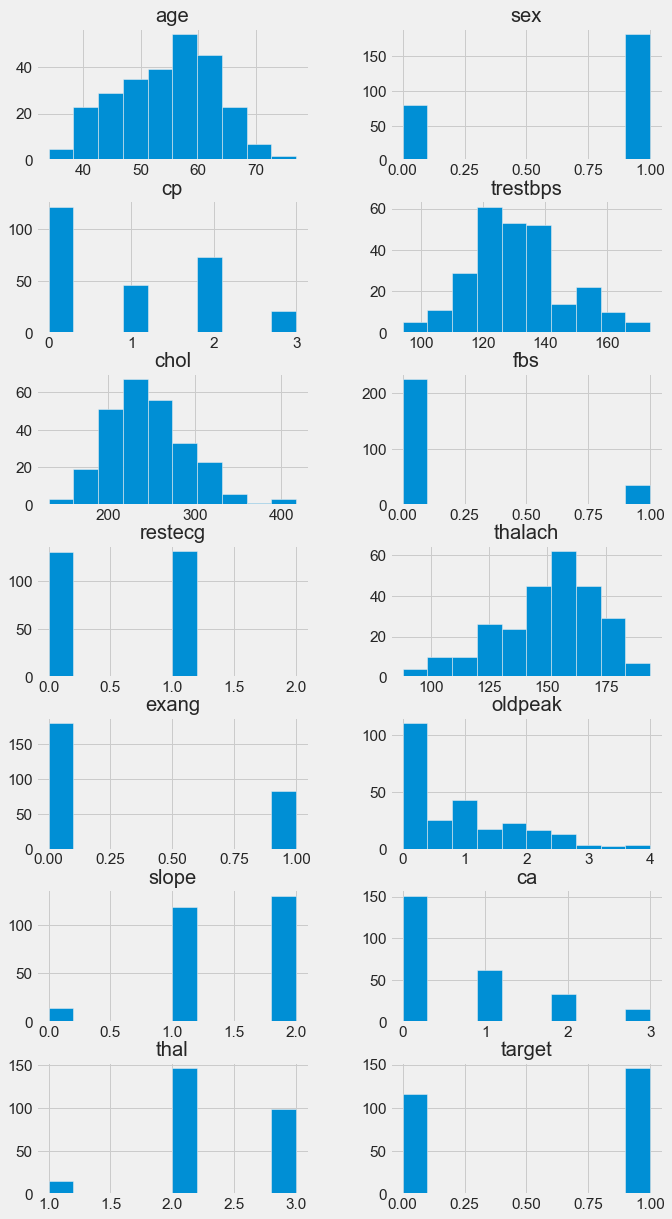

In [398]:
df_cleaned_if.hist(figsize=(10,20), layout=(7,2))

# Plotting correlation matrix of data pre-scaling

<AxesSubplot:>

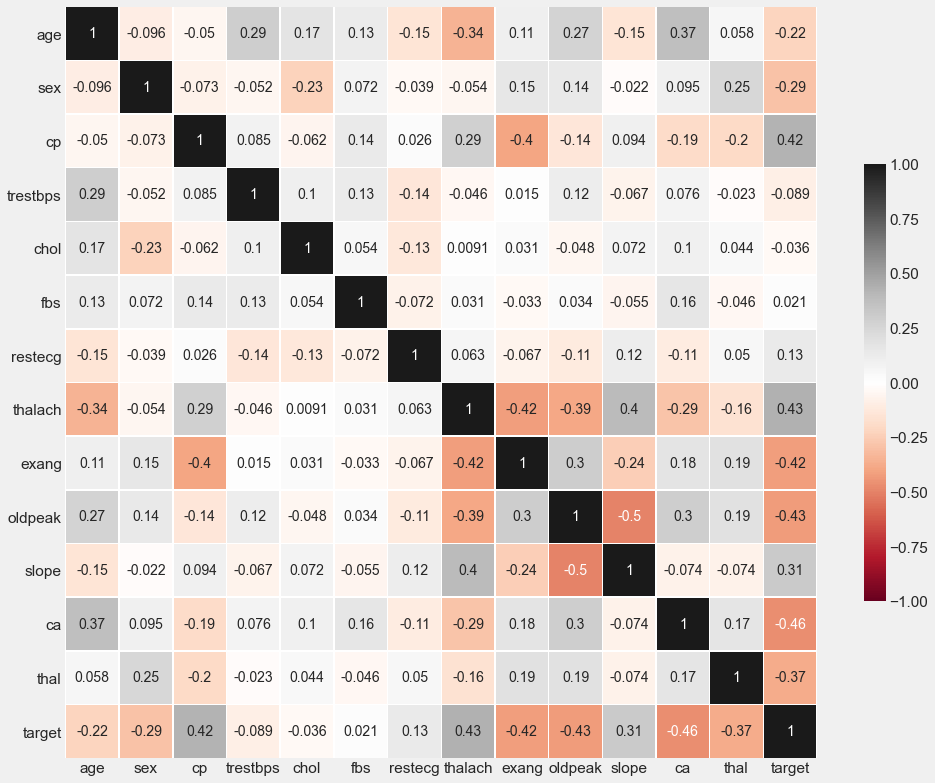

In [399]:
plt.figure(figsize = (15,15))
sns.heatmap(df_cleaned_if.corr(), annot = True, fmt='.2g', vmin=-1, vmax=1, center=0, cmap='RdGy',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [402]:
df_cleaned.reset_index(drop=True, inplace=True)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
292,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
293,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
294,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


# Model selection (with pipelined data preprocessing and model evaluation using accuracy, precission, and recall scores)

## 1/ Using normalization

>LogisticRegression: ideal=[0.847972972972973, 0.4864864864864865, 0.4864864864864865], cv=[0.838505747126437, 0.8360984848484849, 0.888962451377312]
>RidgeClassifier: ideal=[0.847972972972973, 0.4966216216216216, 0.4966216216216216], cv=[0.8419540229885059, 0.8315144318597003, 0.9061303711768108]
>SGDClassifier: ideal=[0.8277027027027027, 0.4560810810810811, 0.4560810810810811], cv=[0.7908045977011494, 0.7873654770992904, 0.8722652785810681]
>PassiveAggressiveClassifier: ideal=[0.7871621621621622, 0.42567567567567566, 0.42567567567567566], cv=[0.7873563218390804, 0.8442515121990827, 0.7556326336202497]
>KNeighborsClassifier: ideal=[0.8175675675675675, 0.4527027027027027, 0.4527027027027027], cv=[0.8250574712643678, 0.8396078431372549, 0.8421473366674604]
>DecisionTreeClassifier: ideal=[0.7567567567567568, 0.4222972972972973, 0.4222972972972973], cv=[0.7226436781609195, 0.7585821393948329, 0.7370242347951327]
>ExtraTreeClassifier: ideal=[0.7297297297297297, 0.3918918918918919, 0.391891

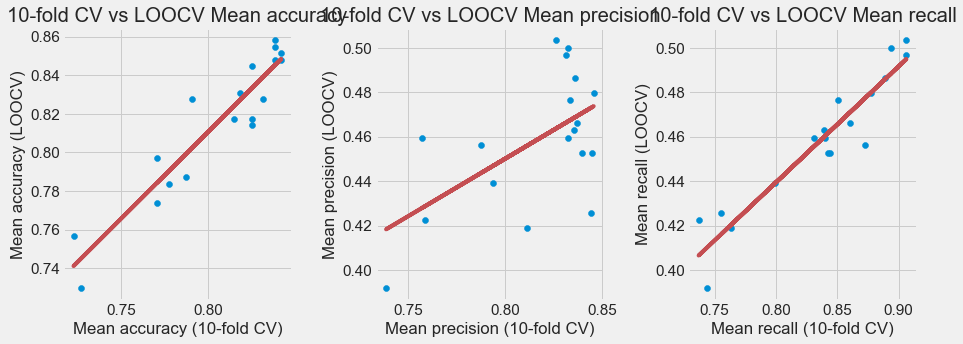

In [449]:
#cite: https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/ 
# correlation between test harness and ideal test condition
from numpy import mean
from numpy import isnan
from numpy import asarray
from numpy import polyfit
from scipy.stats import pearsonr
#from matplotlib import pyplot
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# create the dataset
#def get_dataset(n_samples=100):
#    X, y = make_classification(n_samples=n_samples, n_features=20, n_informative=15, n_redundant=5, random_state=1)
#    return X, y
X = df_cleaned.drop(["target"], 1)
y = df_cleaned["target"]

# get a list of models to evaluate
def get_models():
    models = list()
    models.append(LogisticRegression())
    models.append(RidgeClassifier())
    models.append(SGDClassifier())
    models.append(PassiveAggressiveClassifier())
    models.append(KNeighborsClassifier())
    models.append(DecisionTreeClassifier())
    models.append(ExtraTreeClassifier())
    models.append(LinearSVC())
    models.append(SVC())
    models.append(GaussianNB())
    models.append(AdaBoostClassifier())
    models.append(BaggingClassifier())
    models.append(RandomForestClassifier())
    models.append(ExtraTreesClassifier())
    models.append(GaussianProcessClassifier())
    models.append(GradientBoostingClassifier())
    models.append(LinearDiscriminantAnalysis())
    models.append(QuadraticDiscriminantAnalysis())
    return models

# evaluate the model using a given test condition
def evaluate_model(cv, model):
    #pipeline
    steps=[('scaler',MinMaxScaler()),('model', model)]
    pipeline = Pipeline(steps=steps)
    # evaluate the model
    scores = cross_validate(pipeline, X, y, scoring=['accuracy','precision', 'recall'], cv=cv, n_jobs=-1)
    # return scores
    return [mean(scores['test_accuracy']),mean(scores['test_precision']),mean(scores['test_recall'])]

# define test conditions
ideal_cv = LeaveOneOut()
cv = KFold(n_splits=10, shuffle=True, random_state=1)
# get the list of models to consider
models = get_models()
# collect results
ideal_results, cv_results = list(), list()
# evaluate each model
for model in models:
    # evaluate model using each test condition
    cv_mean = evaluate_model(cv, model)
    ideal_mean = evaluate_model(ideal_cv, model)
    # check for invalid results
    if True in [isnan(i) for i in cv_mean] or True in [isnan(i) for i in ideal_mean]:
        print("error in %s, cv_mean: %r, ideal_mean: %r" % (model, cv_mean,ideal_mean))
        continue
    # store results
    cv_results.append(cv_mean)
    ideal_results.append(ideal_mean)
    # summarize progress
    print('>%s: ideal=%r, cv=%r' % (type(model).__name__, ideal_mean, cv_mean))
# calculate the correlation between each test condition
for name,cv,ideal in zip(['accuracy','precision', 'recall'],np.asarray(cv_results).T,np.asarray(ideal_results).T):
    corr, _ = pearsonr(cv, ideal)
    print('Correlation of %s: %.3f' % (name, corr))
    
fig, axs = plt.subplots(1, 3, figsize=(13,5))
for ax,name,cv,ideal in zip(axs,['accuracy','precision', 'recall'],np.asarray(cv_results).T,np.asarray(ideal_results).T):
    # scatter plot of results
    ax.scatter(cv, ideal)
    # plot the line of best fit
    coeffs = polyfit(cv, ideal, 1)
    fn = np.poly1d(coeffs)
    ax.plot(cv, fn(cv), color='r')
    # label the plot
    ax.set_title('10-fold CV vs LOOCV Mean %s' % name)
    ax.set_xlabel('Mean %s (10-fold CV)' % name)
    ax.set_ylabel('Mean %s (LOOCV)' % name)
plt.tight_layout()#prevent overlapping
# show the plot
plt.show()

## 2/ Using standardization

>LogisticRegression: ideal=[0.8547297297297297, 0.48986486486486486, 0.48986486486486486], cv=[0.8351724137931035, 0.8350651703369095, 0.8794386418535025]
>RidgeClassifier: ideal=[0.8547297297297297, 0.5033783783783784, 0.5033783783783784], cv=[0.8386206896551724, 0.8265144318597004, 0.9061303711768108]
>SGDClassifier: ideal=[0.7905405405405406, 0.44256756756756754, 0.44256756756756754], cv=[0.8111494252873562, 0.8328746051849766, 0.8043602218215222]
>PassiveAggressiveClassifier: ideal=[0.75, 0.4155405405405405, 0.4155405405405405], cv=[0.8011494252873563, 0.8098571182859109, 0.8232944351829801]
>KNeighborsClassifier: ideal=[0.8141891891891891, 0.46283783783783783, 0.46283783783783783], cv=[0.817816091954023, 0.8235577215182477, 0.851077013801472]
>DecisionTreeClassifier: ideal=[0.7567567567567568, 0.4189189189189189, 0.4189189189189189], cv=[0.7260919540229885, 0.7684217171717173, 0.7364747842456819]
>ExtraTreeClassifier: ideal=[0.7162162162162162, 0.41216216216216217, 0.4121621621621

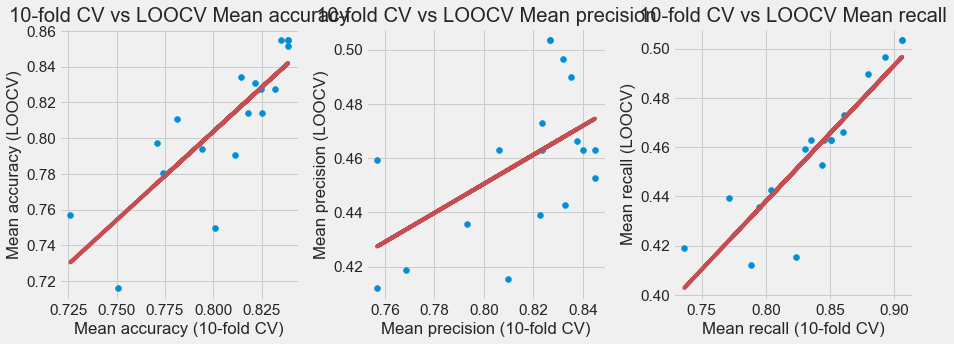

In [451]:
scaler = StandardScaler()
# evaluate the model using a given test condition
def evaluate_model(cv, model):
    #pipeline
    steps=[('scaler',scaler),('model', model)]
    pipeline = Pipeline(steps=steps)
    # evaluate the model
    scores = cross_validate(pipeline, X, y, scoring=['accuracy','precision', 'recall'], cv=cv, n_jobs=-1)
    # return scores
    return [mean(scores['test_accuracy']),mean(scores['test_precision']),mean(scores['test_recall'])]

# define test conditions
ideal_cv = LeaveOneOut()
cv = KFold(n_splits=10, shuffle=True, random_state=1)
# get the list of models to consider
models = get_models()
# collect results
ideal_results, cv_results = list(), list()
# evaluate each model
for model in models:
    # evaluate model using each test condition
    cv_mean = evaluate_model(cv, model)
    ideal_mean = evaluate_model(ideal_cv, model)
    # check for invalid results
    if True in [isnan(i) for i in cv_mean] or True in [isnan(i) for i in ideal_mean]:
        print("error in %s, cv_mean: %r, ideal_mean: %r" % (model, cv_mean,ideal_mean))
        continue
    # store results
    cv_results.append(cv_mean)
    ideal_results.append(ideal_mean)
    # summarize progress
    print('>%s: ideal=%r, cv=%r' % (type(model).__name__, ideal_mean, cv_mean))
# calculate the correlation between each test condition
for name,cv,ideal in zip(['accuracy','precision', 'recall'],np.asarray(cv_results).T,np.asarray(ideal_results).T):
    corr, _ = pearsonr(cv, ideal)
    print('Correlation of %s: %.3f' % (name, corr))
    
fig, axs = plt.subplots(1, 3, figsize=(13,5))
for ax,name,cv,ideal in zip(axs,['accuracy','precision', 'recall'],np.asarray(cv_results).T,np.asarray(ideal_results).T):
    # scatter plot of results
    ax.scatter(cv, ideal)
    # plot the line of best fit
    coeffs = polyfit(cv, ideal, 1)
    fn = np.poly1d(coeffs)
    ax.plot(cv, fn(cv), color='r')
    # label the plot
    ax.set_title('10-fold CV vs LOOCV Mean %s' % name)
    ax.set_xlabel('Mean %s (10-fold CV)' % name)
    ax.set_ylabel('Mean %s (LOOCV)' % name)
plt.tight_layout()#prevent overlapping
# show the plot
plt.show()

# Now choose a model and optimize it:

- We care about high recall score with at least moderate precision since we don't want to misdiagnose heart attacks, also having low precision score is tolerable since the next 2nd test can give more confidence in diagosis

- Some model with high recall scores (> 90% though this may change since cross validation is not perfect) using normalization are: 
 - LinearDiscriminantAnalysis
 - RidgeClassifier

# Splitting data into train and test datasets

In [496]:
X_features = df_cleaned.drop(['target'], axis=1).copy()
y_target = df_cleaned['target'].copy()

x_train, x_test, y_train, y_test = train_test_split(X_features,y_target, test_size=0.3, random_state=3)
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)

# Normalization

In [497]:
norm_transform = MinMaxScaler()
train_processed = norm_transform.fit_transform(x_train)
x_train = pd.DataFrame(train_processed, columns=x_train.columns)

test_processed = norm_transform.fit_transform(x_test)
x_test = pd.DataFrame(test_processed, columns=x_test.columns)

# EDA Visualization (might be useful for project demo slides)

In [458]:
#extract data with >50% of getting heart diease, aka target==1
df_high_risk = df[df['target'] == 1]

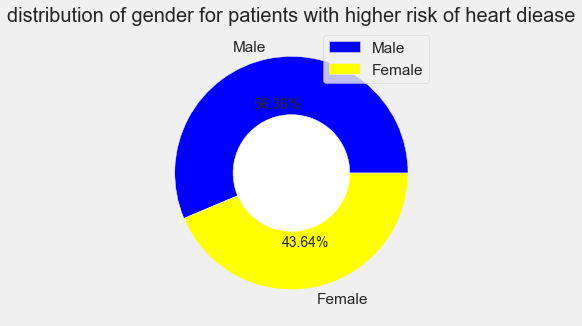

In [459]:
circle = plt.Circle((0, 0), 0.5, color = 'white')

plt.rcParams['figure.figsize'] = (5, 5)
plt.pie(df_high_risk['sex'].value_counts(), colors = ['blue', 'yellow'], labels = ["Male", "Female"], autopct = '%.2f%%')
plt.title('distribution of gender for patients with higher risk of heart diease', fontsize = 20)
plt.gcf().gca().add_artist(circle)
plt.legend()
plt.show()

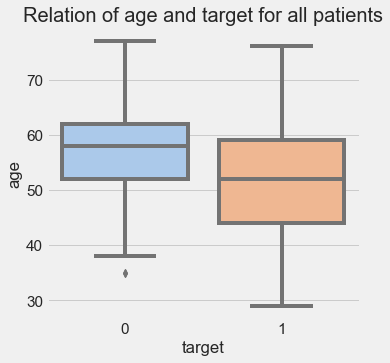

In [460]:
plt.rcParams['figure.figsize'] = (5, 5)
sns.boxplot(x=df['target'], y=df['age'], palette = 'pastel')
plt.title('Relation of age and target for all patients', fontsize = 20)
plt.show()

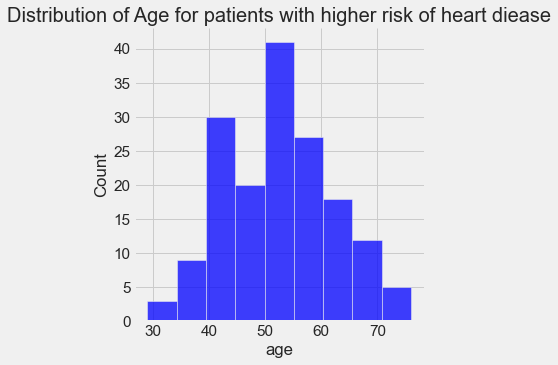

In [461]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (5, 5)
sns.displot(df_high_risk['age'], color = 'blue')
plt.title('Distribution of Age for patients with higher risk of heart diease', fontsize = 20)
plt.show()

<AxesSubplot:>

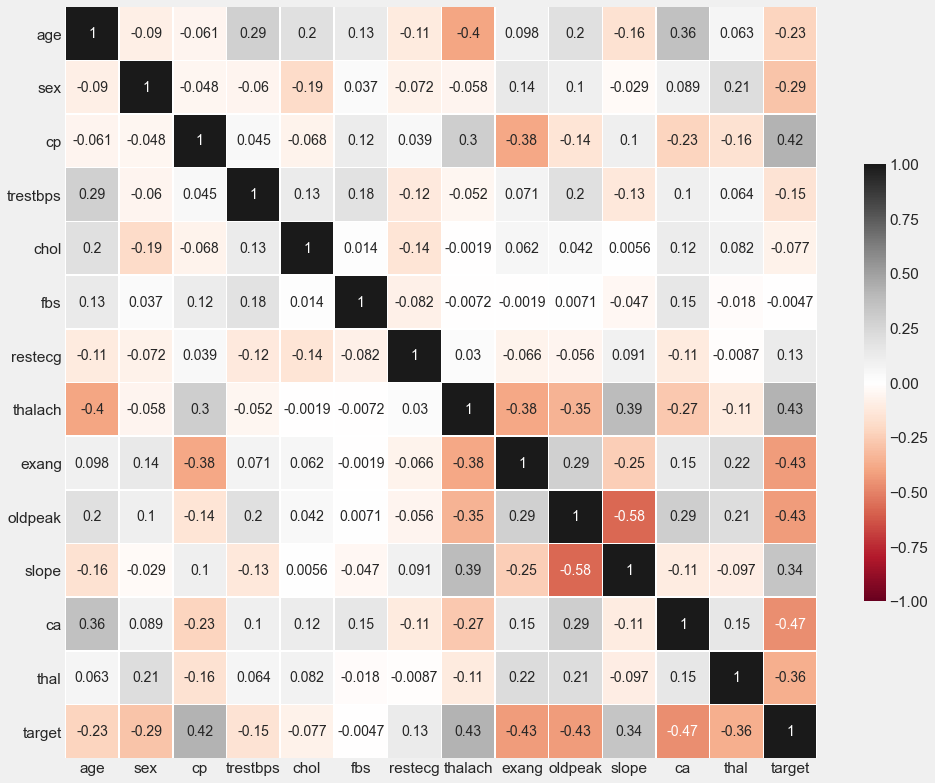

In [462]:
# correlation matrix for numeric variables
plt.figure(figsize = (15,15))
sns.heatmap(df_cleaned.corr(), annot = True, fmt='.2g', vmin=-1, vmax=1, center=0, cmap='RdGy',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Here starts the analysis of the data

In [499]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


In [500]:
age_user=0
sex_user=0
cp_user=0
trestbps_user=0
chol_user=0
fbs_user=0
restecg_user=0
thalach_user=0
exang_user=0
oldpeak_user=0
slope_user=0
ca_user=0
thal_user=0
user_data=[age_user,sex_user,cp_user,trestbps_user,chol_user,fbs_user,restecg_user,thalach_user,exang_user,oldpeak_user,slope_user,ca_user,thal_user]

In [522]:
#x_train,x_test,y_train,y_test = train_test_split(df_cleaned.drop(["target"],1),df_cleaned["target"], test_size=0.3)# random_state=10)

In [523]:
log = LogisticRegression(max_iter=20000)
log.fit(x_train, y_train)
print("weights:")
for i in range(0, len(log.coef_[0])):
    print("b{}: {}".format(i, log.coef_[0][i]))
#print("weights: {}".format(log.coef_[0]))
y_predict = log.predict(x_test)

print("mse: {}".format(mean_squared_error(y_test, y_predict)))

log_pre = precision_score(np.array(y_test).reshape(-1,1),y_predict,average="macro",zero_division=0)
log_recall = recall_score(y_test,y_predict,average="macro",zero_division=0)

print("log precision: {}\n   log recall: {}".format(log_pre, log_recall))
user_predict=log.predict(np.array(user_data).reshape(1,-1))

weights:
b0: -0.005066901752410955
b1: -1.6898248358118941
b2: 0.7985370010201983
b3: -0.041261393278183255
b4: -0.0028806771171606214
b5: 0.6087986832898596
b6: 0.5867168675932805
b7: 0.023757070673190064
b8: -0.8125608802294001
b9: -0.6015517895576568
b10: 0.572147031984465
b11: -1.1058621030935838
b12: -0.6674753924983966
mse: 0.20224719101123595
log precision: 0.7977272727272727
   log recall: 0.7977272727272727


In [524]:
classifier = RandomForestClassifier(n_estimators=50, random_state=0, max_depth = 15)
classifier.fit(x_train, y_train)
y_predict_forest = classifier.predict(x_test)
forestmse= mean_squared_error(y_test,y_predict_forest)
forest_pre = precision_score(np.array(y_test).reshape(-1,1),y_predict_forest,average="macro",zero_division=0)
forest_recall = recall_score(y_test,y_predict_forest,average="macro",zero_division=0)

print("forest mse: {}".format(forestmse))
print("forest precision: {}\n   forest recall: {}".format(forest_pre, forest_recall))

forest mse: 0.20224719101123595
forest precision: 0.7983789260385006
   forest recall: 0.7974747474747474


In [526]:
from sklearn.linear_model import RidgeClassifierCV

clf = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(x_train, y_train)
y_predict_ridge = clf.predict(x_test)
ridge_mse= mean_squared_error(y_test,y_predict_ridge)
ridge_pre = precision_score(np.array(y_test).reshape(-1,1),y_predict_ridge,average="macro",zero_division=0)
ridge_recall = recall_score(y_test,y_predict_ridge,average="macro",zero_division=0)

print("ridge mse: {}".format(ridge_mse))
print("ridge precision: {}\n   ridge recall: {}".format(ridge_pre, ridge_recall))

ridge mse: 0.16853932584269662
ridge precision: 0.8358974358974359
   ridge recall: 0.8308080808080808


# Hyperparameter Tuning

For max depth: 

In [527]:
num_est = [5, 10, 15, 20, 30]
train_scores, test_scores = validation_curve(
                                RandomForestClassifier(),
                                X = x_train, y = y_train, 
                                param_name = 'max_depth', 
                                param_range = num_est, cv = 3)

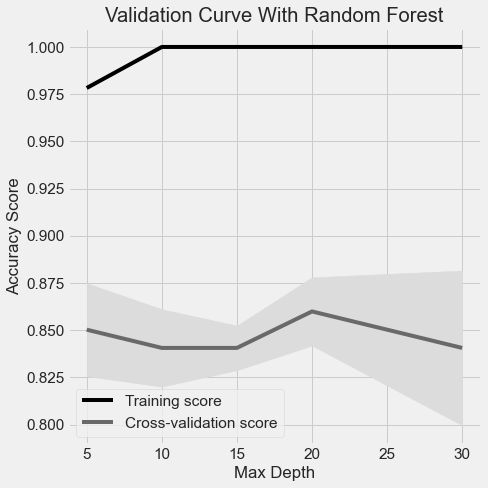

In [528]:
param_range = num_est

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.subplots(1, figsize=(7,7))
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")
plt.title("Validation Curve With Random Forest")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()
# looks like overfitting

# Confusion Matrix

In [529]:
from sklearn.metrics import confusion_matrix
cm_log = confusion_matrix(y_test,y_predict) #log
cm_forest = confusion_matrix(y_test,y_predict_forest) #forest
cm_ridge = confusion_matrix(y_test,y_predict_ridge) #forest

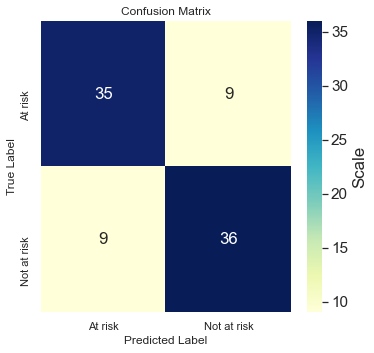

In [530]:
# for log
sns.set(color_codes=True)
plt.figure(1, figsize=(5, 5))
plt.title("Confusion Matrix")
sns.set(font_scale=1.4)
ax = sns.heatmap(cm_log, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'})
ax.set_xticklabels(['At risk','Not at risk'])
ax.set_yticklabels(['At risk','Not at risk'])
ax.set(ylabel="True Label", xlabel="Predicted Label")
plt.show()

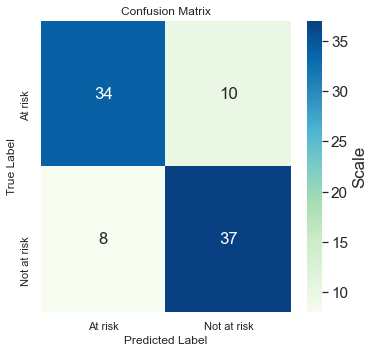

In [531]:
# for forest
sns.set(color_codes=True)
plt.figure(1, figsize=(5, 5))
plt.title("Confusion Matrix")
sns.set(font_scale=1.4)
ax = sns.heatmap(cm_forest, annot=True, cmap="GnBu", cbar_kws={'label': 'Scale'})
ax.set_xticklabels(['At risk','Not at risk'])
ax.set_yticklabels(['At risk','Not at risk'])
ax.set(ylabel="True Label", xlabel="Predicted Label")
plt.show()

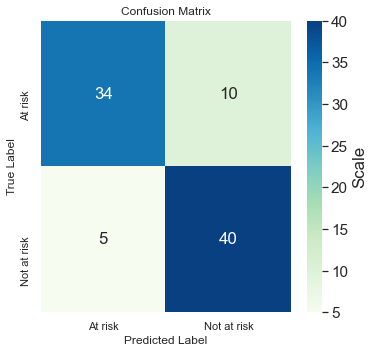

In [532]:
# for ridge classifier
sns.set(color_codes=True)
plt.figure(1, figsize=(5, 5))
plt.title("Confusion Matrix")
sns.set(font_scale=1.4)
ax = sns.heatmap(cm_ridge, annot=True, cmap="GnBu", cbar_kws={'label': 'Scale'})
ax.set_xticklabels(['At risk','Not at risk'])
ax.set_yticklabels(['At risk','Not at risk'])
ax.set(ylabel="True Label", xlabel="Predicted Label")
plt.show()

# Compare Model MSE

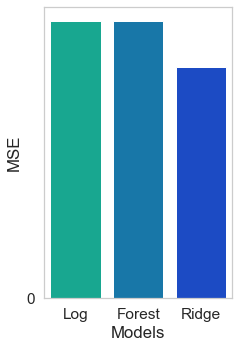

In [533]:
mse_collection = dict()
mse_collection['Log'] = mean_squared_error(y_test, y_predict)
mse_collection['Forest'] = mean_squared_error(y_test,y_predict_forest)
mse_collection['Ridge'] = mean_squared_error(y_test,y_predict_ridge)

sns.set_style("whitegrid")
plt.figure(figsize=(3,5))
plt.yticks(np.arange(0,100,10))
plt.ylabel("MSE")
plt.xlabel("Models")
sns.barplot(x=list(mse_collection.keys()), y=list(mse_collection.values()), palette='winter_r')
plt.show()


# A User's Position in the sample (still under construction)

In [35]:
from plotnine import ggplot, aes, geom_hline, geom_boxplot

user_age = 45

(
  ggplot(df_cleaned)
  + aes(x='sex',y='age')
  + geom_boxplot()
  + geom_hline(yintercept=user_age, color = 'red')
)

ModuleNotFoundError: No module named 'plotnine'

# ROC Curve

In [534]:
from sklearn import metrics

AUC: 0.7977272727272727


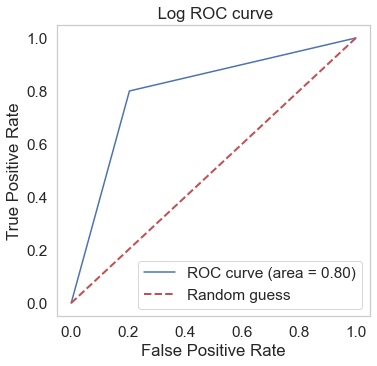

In [535]:
# log
fpr, tpr, thresh = metrics.roc_curve(y_test,y_predict) #log
auc = metrics.auc(fpr, tpr)
print("AUC:", auc)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title(' Log ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

AUC: 0.7974747474747474


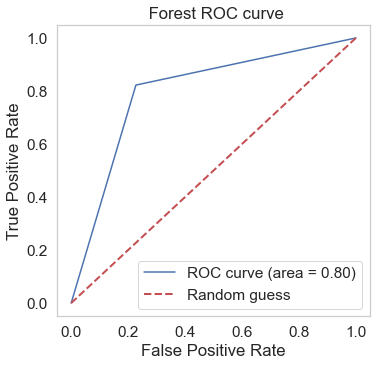

In [536]:
# forest
fpr, tpr, thresh = metrics.roc_curve(y_test,y_predict_forest) #log
auc = metrics.auc(fpr, tpr)
print("AUC:", auc)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title(' Forest ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

AUC: 0.8308080808080808


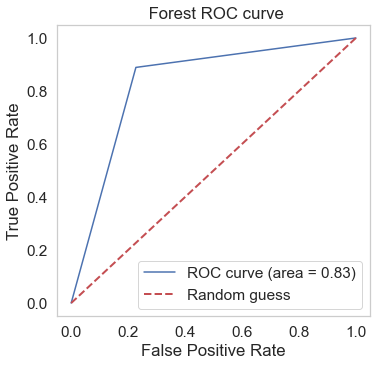

In [537]:
# forest
fpr, tpr, thresh = metrics.roc_curve(y_test,y_predict_ridge) #log
auc = metrics.auc(fpr, tpr)
print("AUC:", auc)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title(' Forest ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()